In [1]:
import sqlalchemy as sql
import pandas as pd
import glob
from os import path, sep
import numpy as np
import matplotlib.pyplot as plt

from numpy.fft import fft, fftshift, fftfreq, ifftshift
from collections import namedtuple

In [2]:
server = "thesis.ca6j6heoraog.eu-central-1.rds.amazonaws.com"
engine = sql.create_engine(f"mysql+pymysql://admin:FphvsYQek4@{server}/thesis_db")
con = engine.connect()

In [3]:
np.random.seed(4455)

partid_query = """
SELECT DISTINCT participant_id
FROM raw_interval_data
"""
participants = [a[0] for a in con.execute(partid_query)]


np.random.shuffle(participants)

In [4]:
signal_sql = sql.text("""
SELECT data_time, data_value
FROM interpolated_interval_data
WHERE participant_id = :par
AND series_type_id = :series_type
AND interpolation_series_id = :interp_type
AND data_value is not null
ORDER BY data_time
""")

In [5]:
def get_signal_by_series_type_and_interp_type(participants, series_type, interp_type):
    for par in participants:
        data = con.execute(signal_sql, par=par, series_type=series_type, interp_type=interp_type)
        yield par, np.array(data.fetchall()).astype(float)


In [6]:
bl_spline = get_signal_by_series_type_and_interp_type(participants, 1, 1)
bl_pw = get_signal_by_series_type_and_interp_type(participants, 1, 4)

In [7]:
p1, y1 = next(bl_spline)
p2, y2 = next(bl_pw)

(290.0, 300.0)

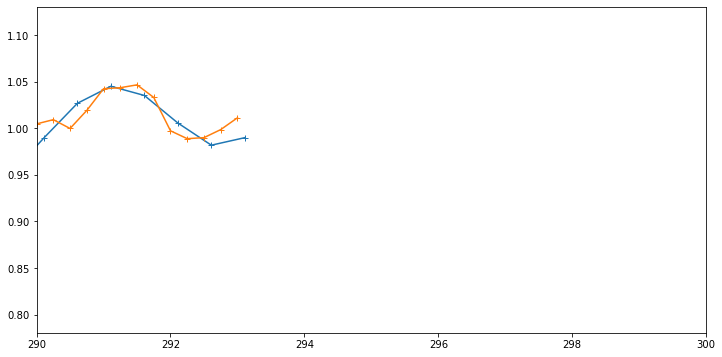

In [8]:

plt.figure(figsize=(12,6))
plt.plot(y1[:,0],y1[:,1],'-+')
plt.plot(y2[:,0]+0.5,y2[:,1],'-+')
plt.xlim(290,300)

In [9]:
y1.shape, y2.shape

((585, 2), (1164, 2))

In [10]:
FFT = namedtuple('FTT','freq,psd_db,psd,phase'.split(','))

In [11]:

def psd(signal, sampling_rate,hide_bias=False):
    n = len(signal)
    windowed_signal = np.hamming(n) * signal
    g = fftshift(fft(windowed_signal))
    psd = np.abs(g)
    psd_db = 10*np.log10(psd)
    freq = fftshift(fftfreq(n, sampling_rate))
    if hide_bias:
        psd_db[int(n/2)-1:int(n/2)+2]=0
    return FFT(freq, psd_db, psd, np.angle(g))


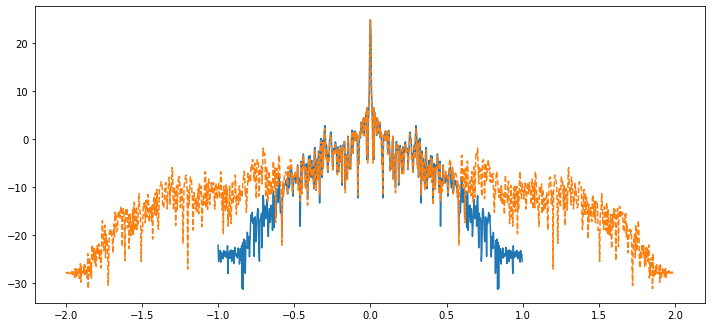

In [12]:

f1, a1, aa1, ph1 = psd(y1[1:-2,1],0.5,False)
f2, a2, aa2, ph2 = psd(y2[:,1],0.25,False)

plt.figure(figsize=(12,12))
plt.subplot(2,1,1)
plt.plot(f1,a1,'-')
#plt.subplot(2,1,2)
plt.plot(f2,a2-3,'--')
#plt.xlim(-0.25, 0.25)

In [13]:
participants

[108,
 206,
 208,
 205,
 186,
 112,
 127,
 241,
 209,
 229,
 178,
 204,
 223,
 103,
 240,
 220,
 192,
 237,
 251,
 224,
 250,
 109,
 236,
 151,
 168,
 179,
 222,
 173,
 249,
 187,
 119,
 114,
 219,
 131,
 230,
 146,
 196,
 177,
 253,
 217,
 145,
 235,
 126,
 221,
 113,
 135,
 238,
 210,
 190,
 256,
 227,
 122,
 155,
 137,
 175,
 116,
 252,
 245,
 182,
 207,
 138,
 183,
 117,
 255,
 176,
 231,
 118,
 215,
 148,
 225,
 142,
 128,
 195,
 115,
 124,
 123,
 167,
 166,
 136,
 172,
 101,
 232,
 141,
 193,
 129,
 194,
 185,
 212,
 121,
 156,
 125,
 164,
 233,
 189,
 165,
 134,
 139,
 174,
 247,
 246,
 211,
 218,
 132,
 180,
 216,
 228,
 191,
 244,
 234,
 140,
 102,
 110,
 213,
 188,
 200,
 214,
 171,
 248,
 202,
 159,
 158,
 133,
 147,
 170,
 203,
 254,
 242,
 130,
 184,
 149,
 181,
 226,
 120,
 239,
 144,
 157,
 169,
 160,
 243,
 111,
 201]

(0.0, 20.0)

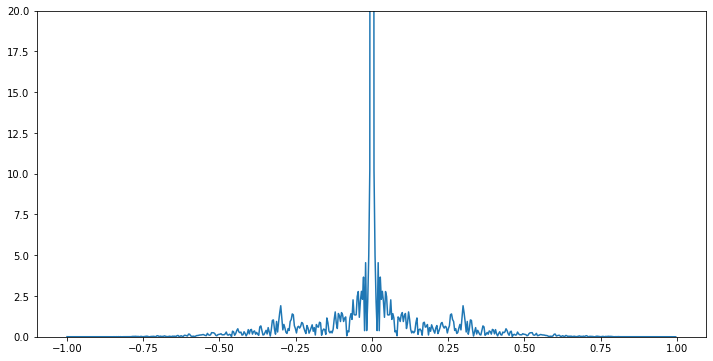

In [14]:
plt.figure(figsize=(12,6))
plt.plot(f1,aa1,'-')
plt.ylim(0,20)

In [15]:
p1, p2

(108, 108)

In [ ]:
fig = plt.figure(figsize=(12,9))
ax1, ax2 = fig.subplots(2,1)
ax1.plot(f1,ph1,'-')
ax1.plot(f2,ph2,'--')
ax1.set_xlim(-0., 0.5)
ax2.plot(f1,a1,'-')
ax2.plot(f2,a2,'--')
ax2.set_xlim(-0., 0.5)


In [ ]:
print(ifftshift(a1)[:8])
print(ifftshift(a2)[:8]-3)
print(ifftshift(f1)[:8])
print(ifftshift(f2)[:8])
print()
print(f1[:8])
print(f2[:8:2]+1)

In [ ]:
plt.subplot(3,1,1)
plt.plot(f1)
plt.subplot(3,1,2)

plt.plot(f2)
plt.subplot(3,1,3)

plt.plot(f1[3:],f2[1::2])
plt.plot(f1[3:],2*f1[3:])

In [ ]:
plt.plot(f1[3:],f2[1::2])
plt.plot(f1[3:],2*f1[3:])

In [ ]:
len(f1)*2,len(f2)

In [ ]:
print(fftfreq(10))
print(fftfreq(20)[::2])


In [ ]:
f, a = psd(y2[:,1],0.5,False)
n2 = int(len(a)/2)
a[n2-1:n2+2]=0
plt.plot(f,a)

In [ ]:
x = np.vstack([np.arange(len(f)),f])
x[:,x[1,:]==0]

In [ ]:
a[305:315]

In [ ]:
int(len(f)/2)